<a href="https://colab.research.google.com/github/daa103/DAA_ESAA/blob/main/%ED%8C%8C%EC%9D%B4%EC%8D%AC_%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D_p303~310.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**4. 사이킷런 Linear Regression을 이용한 보스턴 주택가격예측**

선형모델중 규제가 적용되지 않은 선형회귀를 LinearRegression을 이용해 회귀구현하기

### LinearRegression 클래스-Ordinary Least Squares
* LinearRegression: RSS를 최소화해 OSS 추정방식으로 구현한 클래스
* LinearRegression클래스는 fit()메서드로, X,y배열을 받으면 회귀계수인 W를 coef_속성에 저장

In [2]:
#class sklearn.linear_model.LinearRegression(fit_intercept=True,normalize=False,copy_X=True,n_jobs=1)

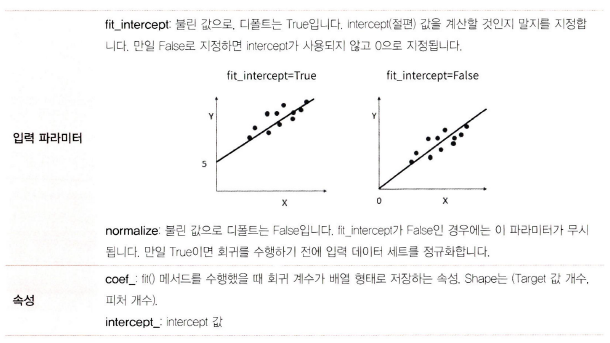

* Ordinary Least Squares 기반 회귀계수 계산은 입력 피처의 독립성에 많은 영향을 받는다.
* 피처간 상관관계높은경우=분산이 크다 : 오류에 민감
 > 다중공선성 문제

 > 이런 피처가 많으면독립적 중요 피처만 남기고 제거하거나 규제 or PCA를 통해 차원축소

 ### 회귀평가지표
 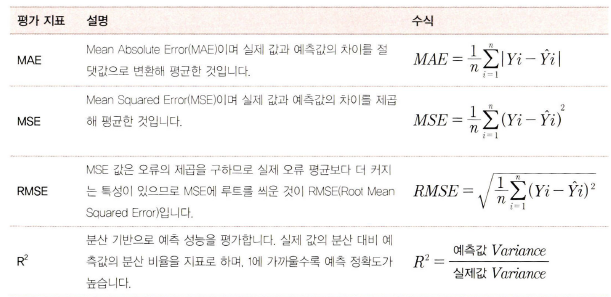


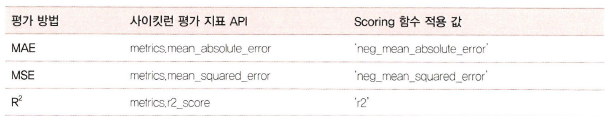

* 유의점
>* cross_Val_score, GridSearchCV와 같은 스코어링 함수에 회귀 평가 지표를 사용할때
>* MAE는 절댓값의 합이기때문에 음수를 가질 수 없는데, 이의 scoring파라미터를 보면 음수가 반환된다: score값이 클수록 좋은 평가로 자동 평가하기 때문
>* 그러나 회귀평가지표값이 커지면 나쁜모델이므로 scoring 함수에 보정필요

###LinearRegression을 이용해 보스턴 주택가격 회귀구현
* 피처설명
> * CRIM: 지역별 범죄 발생률
> * ZM: 25000평방비트를 초과하는 거주지역 비율
> * INDUS: 비상업지역 넓이 비율
> * CHAS: 찰스강에 대한 더미변수
> * NOX: 일산화질소 농도
> * RM:거주할 수 있는 방 개수
> * AGE: 1940년 이전에 건축된 소유 주택의 비율
> * DIS: 5개 주요 고용센터까지의 가중거리
> * RAD: 고속도로 접근 용이도
> * TAX: 10000달러당 재산세율
> * PTRATIO: 지역 교사와 학생비율
> * B: 지역의 흑인 거주비율
> * LSTAT:하위계층비율
> * MEDV: 본인 소유 주택가격

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
# from sklearn.datasets import load_boston  지원불가
%matplotlib inline

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
boston = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :3]])

feature_names=['CRIM',	'ZN',	'INDUS',	'CHAS',	'NOX',	'RM',	'AGE',	'DIS',	'RAD',	'TAX'	,'PTRATIO',	'B'	,'LSTAT',	'PRICE']
bostonDF = pd.DataFrame(boston, columns=feature_names)
print('Boston 데이터 세트 크기:', bostonDF.shape)
bostonDF.head()

Boston 데이터 세트 크기: (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [8]:
bostonDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  PRICE    506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


* 8개의 칼럼에 대해 값이 증가할수록 PRICE의 변화 확인


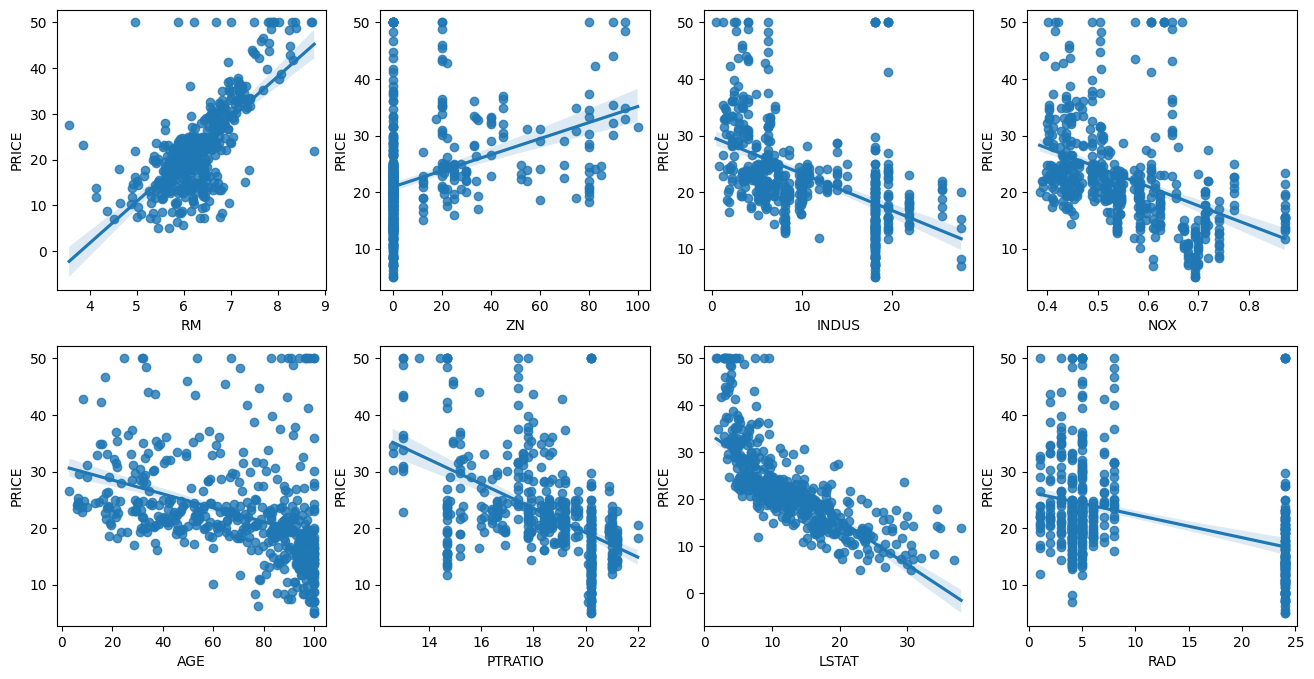

In [9]:
# 2개의 행과 4개의 열을 가진 subplots를 이용. axs는 4x2개의 ax를 가짐.
fig, axs = plt.subplots(figsize=(16,8), ncols=4, nrows=2)
lm_features = ['RM', 'ZN', 'INDUS', 'NOX', 'AGE', 'PTRATIO', 'LSTAT', 'RAD']
for i, feature in enumerate(lm_features):
  row = int(i/4)
  col = i%4
  # 시본의 regplot을 이용해 산점도와 선형 회귀 직선을 함께 표현.
  sns.regplot(x=feature, y='PRICE', data=bostonDF, ax=axs[row][col])

* RM과 LSTAT의 PRICE영향도가 높게 나타난다. 
* 방의 크기가 클수록 가격이 증가
* 하위계층이 적을수록 PRICE증가

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

y_target=bostonDF['PRICE']
X_data=bostonDF.drop(['PRICE'], axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.3, random_state=156)

# 선형 회귀 OLS로 학습/예측/평가 수행.
lr=LinearRegression()
lr.fit(X_train, y_train)
y_preds = lr.predict(X_test)
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)

print('MSE:{0:.3f}, RMSE: {1:.3f}'.format(mse, rmse))
print('Variance score: {0:.3f}'.format(r2_score(y_test, y_preds)))

MSE:17.297, RMSE: 4.159
Variance score: 0.757


In [11]:
print('절편 값:', lr.intercept_) # intercept(절편)
print('회귀 계수 값:', np.round(lr.coef_, 1)) #coefficients(회귀계수)

절편 값: 40.995595172164826
회귀 계수 값: [ -0.1   0.1   0.    3.  -19.8   3.4   0.   -1.7   0.4  -0.   -0.9   0.
  -0.6]


In [12]:
#coef_ 속성은 회귀계수값만 가지고 있으므로 피처별 회귀계수로 다시 매핑하고 높은값순으로 출력
#회귀계수를 큰 값순으로 정렬하기위해 Series로 생성, 인덱스 칼럼명 유의
coeff = pd.Series(data=np.round(lr.coef_, 1), index = X_data.columns)
coeff.sort_values(ascending = False)

RM          3.4
CHAS        3.0
RAD         0.4
ZN          0.1
INDUS       0.0
AGE         0.0
TAX        -0.0
B           0.0
CRIM       -0.1
LSTAT      -0.6
PTRATIO    -0.9
DIS        -1.7
NOX       -19.8
dtype: float64

RMSE제공X, MSE수치를 변환시킨다

In [13]:
from sklearn.model_selection import cross_val_score

y_taret = bostonDF["PRICE"]
X_data = bostonDF.drop(['PRICE'], axis=1, inplace=False)
lr = LinearRegression()

# cross_val_score()로 5 폴드 세트로 MSE를 구한 뒤 이를 기반으로 다시 RMSE 구함.
neg_mse_scores = cross_val_score(lr, X_data, y_target, scoring = 'neg_mean_squared_error', cv=5)
rmse_scores = np.sqrt(-1*neg_mse_scores)
avg_rmse=np.mean(rmse_scores)

# cross_val_score(scoring="neg_mean_squared_error")로 반환된 값은 모두 음수
print('5 folds의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 2))
print('5 folds의 개별 RMSE scores: ', np.round(rmse_scores, 2))
print('5 folds의 평균 RMSE: {0:.3f}'.format(avg_rmse))

5 folds의 개별 Negative MSE scores:  [-12.46 -26.05 -33.07 -80.76 -33.31]
5 folds의 개별 RMSE scores:  [3.53 5.1  5.75 8.99 5.77]
5 folds의 평균 RMSE: 5.829
